In [1]:
import torch
from torch.distributions import Normal, Uniform, MultivariateNormal

from Bs import Bs
from ParticleCloud import ParticleCloud
import matplotlib.pyplot as plt

from IPython.display import display

In [10]:
from torch.distributions import Distribution
    
class Prior:
    def __init__(self, dists: list[Distribution]):
        self.dists = dists
        self.dim = len(dists)

    def sample(self, n_samples: int = 1) -> torch.Tensor:
        samples = [dist.sample((n_samples,)) for dist in self.dists]
        return torch.stack(samples, dim=-1).squeeze()

    def log_prob(self, x: torch.Tensor) -> torch.Tensor:
        log_probs = []
        for i, d in enumerate(self.dists):
            mask = (x[:, i] > d.low) & (x[:, i] < d.high)
            lp = torch.full_like(x[:, i], -10**3.0)
            lp[mask] = d.log_prob(x[:, i][mask])

            log_probs.append(lp)
        return torch.stack(log_probs, dim=-1).sum(dim=-1)

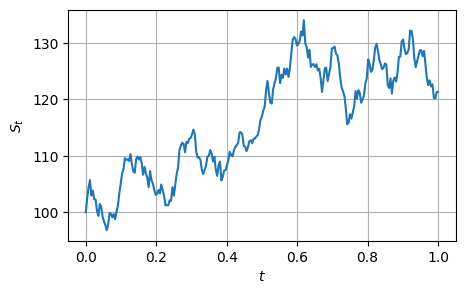

In [11]:
torch.manual_seed(42)

dt = torch.tensor(1 / 252)
model = Bs(dt=dt)
T = 1.0

S0 = torch.tensor(100.0)
params = torch.tensor([[0.1, 0.2]])
S = model.simulate(params, S0, T, M=1)

plt.figure(figsize=(5,3))
plt.plot(torch.linspace(0, T, len(S)), S.detach())
plt.xlabel(r'$t$')
plt.ylabel(r'$S_t$')
plt.grid()
plt.show()

In [260]:
#torch.manual_seed(0)
pi_0 = Prior(dists = [Uniform(-0.5, 0.5), Uniform(1e-4, 1.0)])
n_particles = 100

pc = ParticleCloud(model, pi_0, n_particles, tau = 0.1)

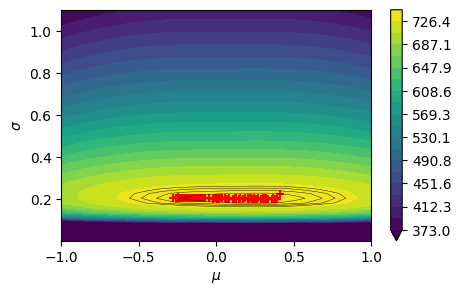

In [272]:
data = S[:, 0]
fig = pc.plot(data)
pc.update_gd(data, n_steps = 1, lr = 0.001)